# Introduction
State notebook purpose here

### Imports
Import libraries and write settings here.

In [5]:
# Notebooks specific imports
from IPython import get_ipython
ipython = get_ipython()
#Expand notebook display

from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload
%autoreload 2
from tqdm.notebook import tqdm

# Basic useful imports
import re
import time
import yaml
from pprint import pprint
from pathlib import Path
import h5py
import warnings

# Data manipulation
import numpy as np
from scipy.special import erf
from scipy.integrate import quad, solve_ivp
import scipy.stats as stats
from scipy.signal import savgol_filter
from scipy.spatial import ConvexHull
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
from matplotlib.patches import (Circle, RegularPolygon, FancyArrowPatch, ArrowStyle)
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, NullFormatter)
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
from dyn_cond_fig_functions import *

# Clustering stuff
from sklearn.cluster import MeanShift, estimate_bandwidth, DBSCAN, OPTICS
from itertools import cycle
# plt.cm.tab20.colors

# From alens_analysis.py
import alens_analysis as aa
import alens_analysis.chromatin as aac
import alens_analysis.chromatin.chrom_analysis as ca
import alens_analysis.chromatin.chrom_condensate_analysis as cca
import alens_analysis.chromatin.chrom_graph_funcs as cgf
from alens_analysis import cluster_analysis as cla

from alens_analysis.colormaps import register_cmaps

# Locations
ceph_path = Path.home() / 'ceph/DATA/Chromatin/DynCondPaper'



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
cpu


### Style settings

In [6]:
graph_sty = {
    "axes.titlesize": 20,
    "axes.labelsize": 24,
    "lines.linewidth": 2,
    "lines.markersize": 2,
    "xtick.labelsize": 24,
    "ytick.labelsize": 24,
    "font.size": 20,
    "font.sans-serif": 'DejaVu Sans',
    "text.usetex": False,
    'mathtext.fontset': 'cm',
}
plt.style.use(graph_sty)

colors = cycle(mcolors.XKCD_COLORS.keys())

# register_cmaps()
plt.rcParams['image.cmap'] = 'YlOrRd'
        

In [7]:
def get_strand_length(dset0, dset1):

    time_arr0 = dset0[:,0]
    time_arr1 = dset1[:,0]
    common_times = np.intersect1d(time_arr0, time_arr1)
    dset_common0 = dset0[np.where(np.isin(time_arr0, common_times))[0]]
    dset_common1 = dset1[np.where(np.isin(time_arr1, common_times))[0]]

    clust_size_arr0 = dset_common0[:,1]
    clust_center_arr0 = dset_common0[:,2]
    left_edge0 = clust_center_arr0 - clust_size_arr0*.5
    right_edge0 = clust_center_arr0 + clust_size_arr0*.5

    clust_size_arr1 = dset_common1[:,1]
    clust_center_arr1 = dset_common1[:,2]
    left_edge1 = clust_center_arr1 - clust_size_arr1*.5
    right_edge1 = clust_center_arr1 + clust_size_arr1*.5

    strand_size = left_edge1 - right_edge0 if left_edge1[0] - right_edge0[0] > 0 else left_edge0 - right_edge1

    return strand_size, common_times

def cond_evolve_with_free_energy_param_deriv(t, l, l_tot, gamma, alpha, prefactor=.021):
    gamma_prime = 8 * np.power(6, 2.0 / 3.0) * alpha * gamma * np.cbrt(np.pi / alpha)
    return -prefactor* gamma_prime * (np.power(l, -1/3) - np.power(l_tot-l, -1/3))

def cond_evolve_with_tau(t, l, l_tot, tau):
    return -(np.power(l, -1/3) - np.power(l_tot-l, -1/3))/(tau * np.power(l_tot, -4./3.))
    


# Figure 8

3922
4652
7321
7416
8092
Slope: 0.04630588240430417
Intercept: 58.62331782964447
R-squared: 0.573026816491236


4.588142181763206


/var/folders/st/fgw_z95d55x71m603j17ld300000gr/T/ipykernel_34260/938572626.py:28: RuntimeWarning: invalid value encountered in power
  return -(np.power(l, -1/3) - np.power(l_tot-l, -1/3))/(tau * np.power(l_tot, -4./3.))


FileNotFoundError: [Errno 2] No such file or directory: '/mnt/home/alamson/papers/dyn_cond_paper/images/fig8_dissolve_event_sync.png'

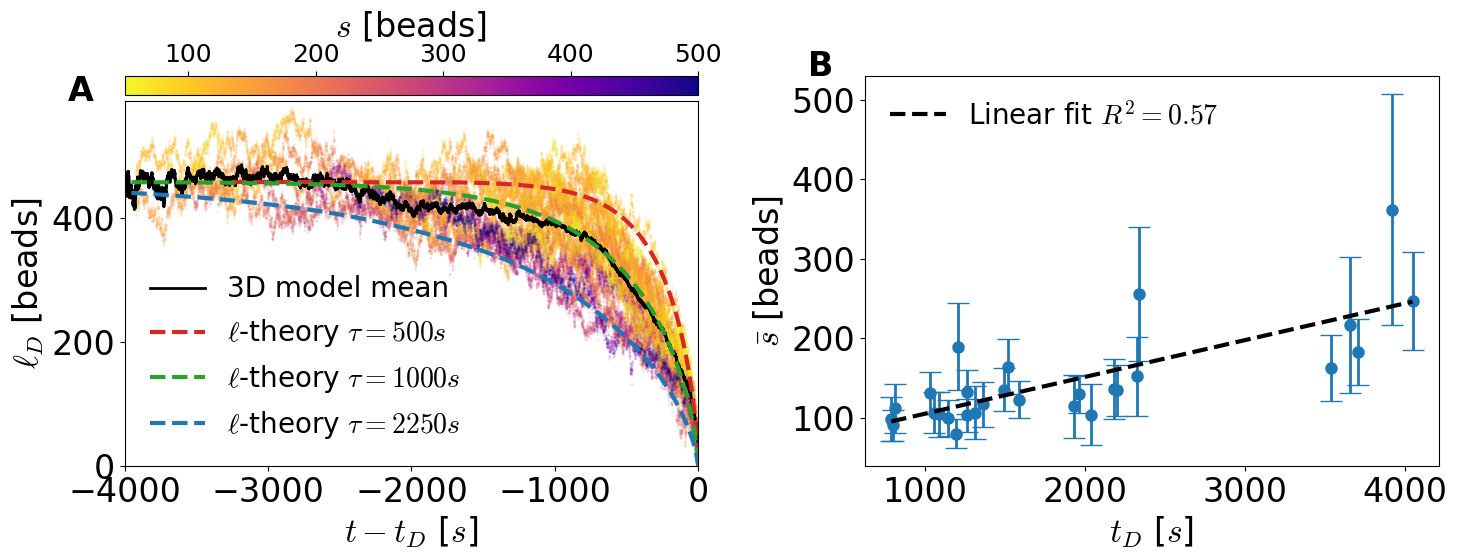

In [8]:
fig, axarr = plt.subplots(1,2, figsize=(15,6))
plot_params = {"linewidth": 1, "markersize": .5, "marker":'', "alpha":0.3, "linestyle":'-'}

lifetime_arr = []
strand_avg_length_arr = []
strand_std_length_arr = []
cluster_size_list = []
largest_time_arr = []
max_strand_size = 0
min_strand_size = -1
vmin = 50
vmax = 500
with h5py.File("Figure7/fig7_cluster_data.h5", 'r') as h5_graph:
    dset_list = list(h5_graph['dissolve'].items())
    for i in range(0,len(h5_graph['dissolve'].items()), 2):
        name0, d_set0 = dset_list[i]
        name1, d_set1 = dset_list[i+1]
        try:
            strand_size_arr, common_times = get_strand_length(d_set0, d_set1)
            # Find dissolving dset (time indices are reversed)
            dissolve_dset = d_set0 if d_set0[0,1] < d_set1[0,1] else d_set1
            dissolve_dset = dissolve_dset[np.where(np.isin(dissolve_dset[:,0], common_times))[0]]
            time_arr = dissolve_dset[:,0]
            last_time_step = max(time_arr)
            if len(largest_time_arr) < len(time_arr):
                print(len(time_arr))
                largest_time_arr = time_arr

            lifetime_arr += [time_arr[0] - time_arr[-1]]
            strand_avg_length_arr += [np.mean(strand_size_arr)]
            strand_std_length_arr += [np.std(strand_size_arr)]

            scatter = axarr[0].scatter(time_arr-last_time_step, dissolve_dset[:,1], s=1, c=strand_size_arr, cmap='plasma_r',  vmin=vmin, vmax=vmax, alpha=0.1)
            cluster_size_list += [dissolve_dset[:,1]]

            # For sizing of scale bar purposes
            max_strand_size = max(max_strand_size, max(strand_size_arr))
            if min_strand_size == -1:
                min_strand_size = min(strand_size_arr)
            min_strand_size = min(min_strand_size, min(strand_size_arr))

        except:
            raise
            print("Error")
            print(name0, name1)
            pass

    mean_size_arr = mean_of_arrays(cluster_size_list)
    last_time_step = max(largest_time_arr)
    _ = axarr[0].plot(largest_time_arr-last_time_step, mean_size_arr, label="3D model mean", color='k')

    avg_scat = axarr[1].errorbar(lifetime_arr, strand_avg_length_arr, yerr=strand_std_length_arr, fmt='o', color='tab:blue', markersize=8,  capsize=8)

    # weights = 1 / np.power(strand_std_length_arr, 2)
    weights = np.ones(len(strand_std_length_arr))
    coefficients = np.polyfit(lifetime_arr, strand_avg_length_arr, deg=1, w=weights)
    slope, intercept = coefficients

    # Calculate R-squared
    p = np.poly1d(coefficients)
    y_fit = p(lifetime_arr)
    ss_res = np.sum(weights * (strand_avg_length_arr - y_fit)**2)
    ss_tot = np.sum(weights * (strand_avg_length_arr - np.average(strand_avg_length_arr, weights=weights))**2)
    r_squared = 1 - (ss_res / ss_tot)

    # Print the results
    print(f"Slope: {slope}")
    print(f"Intercept: {intercept}")
    print(f"R-squared: {r_squared}")
    x = np.linspace(min(lifetime_arr), max(lifetime_arr), 100)
    axarr[1].plot(x, p(x), color='k', linestyle='--', linewidth=3, label=rf"Linear fit $R^2={r_squared:.2f}$", zorder=10)

    # cax2 = make_axes_locatable(axarr[1]).append_axes("top", size="5%", pad=0.06)
    cax1 = make_axes_locatable(axarr[0]).append_axes("top", size="5%", pad=0.06)

    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    sm = mpl.cm.ScalarMappable(cmap='plasma_r', norm=norm)
    cbar1 = fig.colorbar(sm,  cax=cax1, orientation='horizontal', fraction=0.02, pad=0.04, alpha=1.0)
    # cbar2 = fig.colorbar(avg_scat,  cax=cax2, orientation='horizontal', fraction=0.02, pad=0.04, alpha=1.0)

    cbar1.ax.xaxis.set_ticks_position('top')
    cbar1.ax.xaxis.set_label_position('top')
    cbar1.ax.tick_params(labelsize=18)
    cbar1.set_label(r'$s$ [beads]')

    # cbar2.ax.xaxis.set_ticks_position('top')
    # cbar2.ax.xaxis.set_label_position('top')
    # cbar2.ax.tick_params(labelsize=18)
    # cbar2.set_label(r'$\sqrt{\overline{s^2} -  \bar{s}^2}$ [beads]')

# Renger et al. parameters
tmax = 1e6
kappa = 0.0822
nu = 4.1
gamma = 0.15
alpha = 0.05
beta = 1.0 / 0.0041
b = 0.01
Lc = 16
L=5

max_ld = calc_max_length_in_two_condensates(L, Lc, nu, alpha, gamma, kappa)
print(max_ld)

sol = solve_ivp(
    cond_evolve_with_tau,
    [0, tmax],
    [max_ld + 0.0001, max_ld - 0.0001],
    args=[2*max_ld, 500],
    dense_output=True,
)
t_eval = np.linspace(0, sol.t[-1], 1000)
l_eval = sol.sol(t_eval)
_ = axarr[0].plot((t_eval - t_eval[-1]), l_eval[1]/b, color="C3", label=rf"$\ell$-theory $\tau=500s$ ", linestyle="--", linewidth=3)

sol = solve_ivp(
    cond_evolve_with_tau,
    [0, tmax],
    [max_ld + 0.0001, max_ld - 0.0001],
    args=[2*max_ld, 1000],
    dense_output=True,
)
t_eval = np.linspace(0, sol.t[-1], 1000)
l_eval = sol.sol(t_eval)
_ = axarr[0].plot((t_eval - t_eval[-1]), l_eval[1]/b, color="C2", label=rf"$\ell$-theory $\tau=1000s$ ", linestyle="--", linewidth=3)

sol = solve_ivp(
    cond_evolve_with_tau,
    [0, tmax],
    [max_ld + 0.0001, max_ld - 0.0001],
    args=[2*max_ld, 2250],
    dense_output=True,
)
t_eval = np.linspace(0, sol.t[-1], 1000)
l_eval = sol.sol(t_eval)
_ = axarr[0].plot((t_eval - t_eval[-1]), l_eval[1]/b, color="C0", label=rf"$\ell$-theory $\tau=2250s$ ", linestyle="--", linewidth=3)


_ = axarr[0].text(-0.1, 1, "A", fontsize=24, transform=axarr[0].transAxes, fontweight='bold')
_ = axarr[1].text(-0.1, 1, "B", fontsize=24, transform=axarr[1].transAxes, fontweight='bold')
_ = axarr[0].set_ylabel("$\ell_D$ [beads]")
_ = axarr[0].set_xlabel("$t - t_D$ [$s$]")
_ = axarr[1].set_ylabel(r"$\bar{s}$ [beads]")   
_ = axarr[1].set_xlabel("$t_D$ [$s$]")
_ = axarr[0].legend(frameon=False)
_ = axarr[0].set_xlim(-4000, 0)
_ = axarr[0].set_ylim(0, 590)
_ = axarr[1].legend(frameon=False)
fig.tight_layout()

fig.savefig("Figure8/fig8_dissolve_event_sync.png", dpi=600,bbox_inches='tight')
fig.savefig("/mnt/home/alamson/papers/dyn_cond_paper/images/fig8_dissolve_event_sync.png", dpi=300, bbox_inches="tight")


3922
4652
7321
7416
8092
Slope: 0.03170488220604269
Intercept: 66.73265905379618
R-squared: 0.49635642448991946


4.588142181763206


/tmp/ipykernel_415757/938572626.py:28: RuntimeWarning: invalid value encountered in power
  return -(np.power(l, -1/3) - np.power(l_tot-l, -1/3))/(tau * np.power(l_tot, -4./3.))


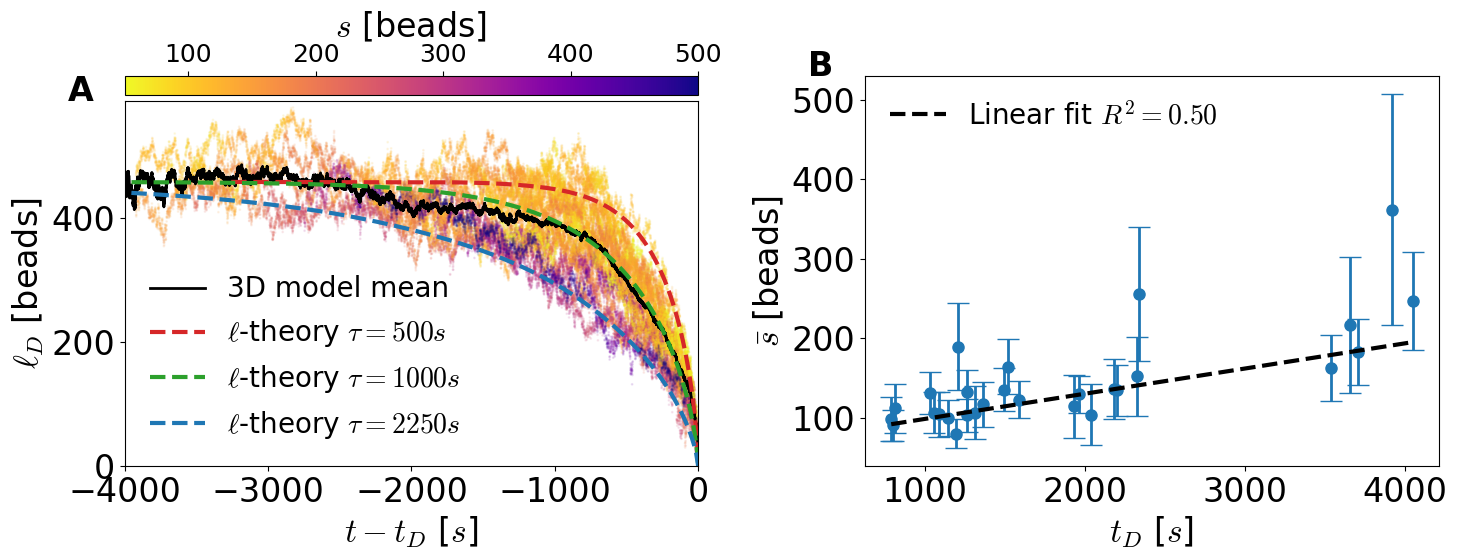

In [ ]:
fig, axarr = plt.subplots(1,2, figsize=(15,6))
plot_params = {"linewidth": 1, "markersize": .5, "marker":'', "alpha":0.3, "linestyle":'-'}

lifetime_arr = []
strand_avg_length_arr = []
strand_std_length_arr = []
cluster_size_list = []
largest_time_arr = []
max_strand_size = 0
min_strand_size = -1
vmin = 50
vmax = 500
with h5py.File("Figure7/fig7_cluster_data.h5", 'r') as h5_graph:
    dset_list = list(h5_graph['dissolve'].items())
    for i in range(0,len(h5_graph['dissolve'].items()), 2):
        name0, d_set0 = dset_list[i]
        name1, d_set1 = dset_list[i+1]
        try:
            strand_size_arr, common_times = get_strand_length(d_set0, d_set1)
            # Find dissolving dset (time indices are reversed)
            dissolve_dset = d_set0 if d_set0[0,1] < d_set1[0,1] else d_set1
            dissolve_dset = dissolve_dset[np.where(np.isin(dissolve_dset[:,0], common_times))[0]]
            time_arr = dissolve_dset[:,0]
            last_time_step = max(time_arr)
            if len(largest_time_arr) < len(time_arr):
                print(len(time_arr))
                largest_time_arr = time_arr

            lifetime_arr += [time_arr[0] - time_arr[-1]]
            strand_avg_length_arr += [np.mean(strand_size_arr)]
            strand_std_length_arr += [np.std(strand_size_arr)]

            scatter = axarr[0].scatter(time_arr-last_time_step, dissolve_dset[:,1], s=1, c=strand_size_arr, cmap='plasma_r',  vmin=vmin, vmax=vmax, alpha=0.1)
            cluster_size_list += [dissolve_dset[:,1]]

            # For sizing of scale bar purposes
            max_strand_size = max(max_strand_size, max(strand_size_arr))
            if min_strand_size == -1:
                min_strand_size = min(strand_size_arr)
            min_strand_size = min(min_strand_size, min(strand_size_arr))

        except:
            raise
            print("Error")
            print(name0, name1)
            pass

    mean_size_arr = mean_of_arrays(cluster_size_list)
    last_time_step = max(largest_time_arr)
    _ = axarr[0].plot(largest_time_arr-last_time_step, mean_size_arr, label="3D model mean", color='k')

    avg_scat = axarr[1].errorbar(lifetime_arr, strand_avg_length_arr, yerr=strand_std_length_arr, fmt='o', color='tab:blue', markersize=8,  capsize=8)

    weights = 1 / np.power(strand_std_length_arr, 2)
    # weights = 1 / np.array(strand_std_length_arr)
    coefficients = np.polyfit(lifetime_arr, strand_avg_length_arr, deg=1, w=weights)
    slope, intercept = coefficients

    # Calculate R-squared
    p = np.poly1d(coefficients)
    y_fit = p(lifetime_arr)
    ss_res = np.sum(weights * (strand_avg_length_arr - y_fit)**2)
    ss_tot = np.sum(weights * (strand_avg_length_arr - np.average(strand_avg_length_arr, weights=weights))**2)
    r_squared = 1 - (ss_res / ss_tot)

    # Print the results
    print(f"Slope: {slope}")
    print(f"Intercept: {intercept}")
    print(f"R-squared: {r_squared}")
    x = np.linspace(min(lifetime_arr), max(lifetime_arr), 100)
    axarr[1].plot(x, p(x), color='k', linestyle='--', linewidth=3, label=rf"Linear fit $R^2={r_squared:.2f}$", zorder=10)

    # cax2 = make_axes_locatable(axarr[1]).append_axes("top", size="5%", pad=0.06)
    cax1 = make_axes_locatable(axarr[0]).append_axes("top", size="5%", pad=0.06)

    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    sm = mpl.cm.ScalarMappable(cmap='plasma_r', norm=norm)
    cbar1 = fig.colorbar(sm,  cax=cax1, orientation='horizontal', fraction=0.02, pad=0.04, alpha=1.0)
    # cbar2 = fig.colorbar(avg_scat,  cax=cax2, orientation='horizontal', fraction=0.02, pad=0.04, alpha=1.0)

    cbar1.ax.xaxis.set_ticks_position('top')
    cbar1.ax.xaxis.set_label_position('top')
    cbar1.ax.tick_params(labelsize=18)
    cbar1.set_label(r'$s$ [beads]')

    # cbar2.ax.xaxis.set_ticks_position('top')
    # cbar2.ax.xaxis.set_label_position('top')
    # cbar2.ax.tick_params(labelsize=18)
    # cbar2.set_label(r'$\sqrt{\overline{s^2} -  \bar{s}^2}$ [beads]')

# Renger et al. parameters
tmax = 1e6
kappa = 0.0822
nu = 4.1
gamma = 0.15
alpha = 0.05
beta = 1.0 / 0.0041
b = 0.01
Lc = 16
L=5

max_ld = calc_max_length_in_two_condensates(L, Lc, nu, alpha, gamma, kappa)
print(max_ld)

sol = solve_ivp(
    cond_evolve_with_tau,
    [0, tmax],
    [max_ld + 0.0001, max_ld - 0.0001],
    args=[2*max_ld, 500],
    dense_output=True,
)
t_eval = np.linspace(0, sol.t[-1], 1000)
l_eval = sol.sol(t_eval)
_ = axarr[0].plot((t_eval - t_eval[-1]), l_eval[1]/b, color="C3", label=rf"$\ell$-theory $\tau=500s$ ", linestyle="--", linewidth=3)

sol = solve_ivp(
    cond_evolve_with_tau,
    [0, tmax],
    [max_ld + 0.0001, max_ld - 0.0001],
    args=[2*max_ld, 1000],
    dense_output=True,
)
t_eval = np.linspace(0, sol.t[-1], 1000)
l_eval = sol.sol(t_eval)
_ = axarr[0].plot((t_eval - t_eval[-1]), l_eval[1]/b, color="C2", label=rf"$\ell$-theory $\tau=1000s$ ", linestyle="--", linewidth=3)

sol = solve_ivp(
    cond_evolve_with_tau,
    [0, tmax],
    [max_ld + 0.0001, max_ld - 0.0001],
    args=[2*max_ld, 2250],
    dense_output=True,
)
t_eval = np.linspace(0, sol.t[-1], 1000)
l_eval = sol.sol(t_eval)
_ = axarr[0].plot((t_eval - t_eval[-1]), l_eval[1]/b, color="C0", label=rf"$\ell$-theory $\tau=2250s$ ", linestyle="--", linewidth=3)


_ = axarr[0].text(-0.1, 1, "A", fontsize=24, transform=axarr[0].transAxes, fontweight='bold')
_ = axarr[1].text(-0.1, 1, "B", fontsize=24, transform=axarr[1].transAxes, fontweight='bold')
_ = axarr[0].set_ylabel("$\ell_D$ [beads]")
_ = axarr[0].set_xlabel("$t - t_D$ [$s$]")
_ = axarr[1].set_ylabel(r"$\bar{s}$ [beads]")   
_ = axarr[1].set_xlabel("$t_D$ [$s$]")
_ = axarr[0].legend(frameon=False)
_ = axarr[0].set_xlim(-4000, 0)
_ = axarr[0].set_ylim(0, 590)
_ = axarr[1].legend(frameon=False)
fig.tight_layout()

# fig.savefig("Figure8/fig8_dissolve_event_sync.png", dpi=600,bbox_inches='tight')
# fig.savefig("/mnt/home/alamson/papers/dyn_cond_paper/images/fig8_dissolve_event_sync.png", dpi=300, bbox_inches="tight")


3922
4652
7321
7416
8092
4.588142181763206


/tmp/ipykernel_615598/938572626.py:28: RuntimeWarning: invalid value encountered in power
  return -(np.power(l, -1/3) - np.power(l_tot-l, -1/3))/(tau * np.power(l_tot, -4./3.))


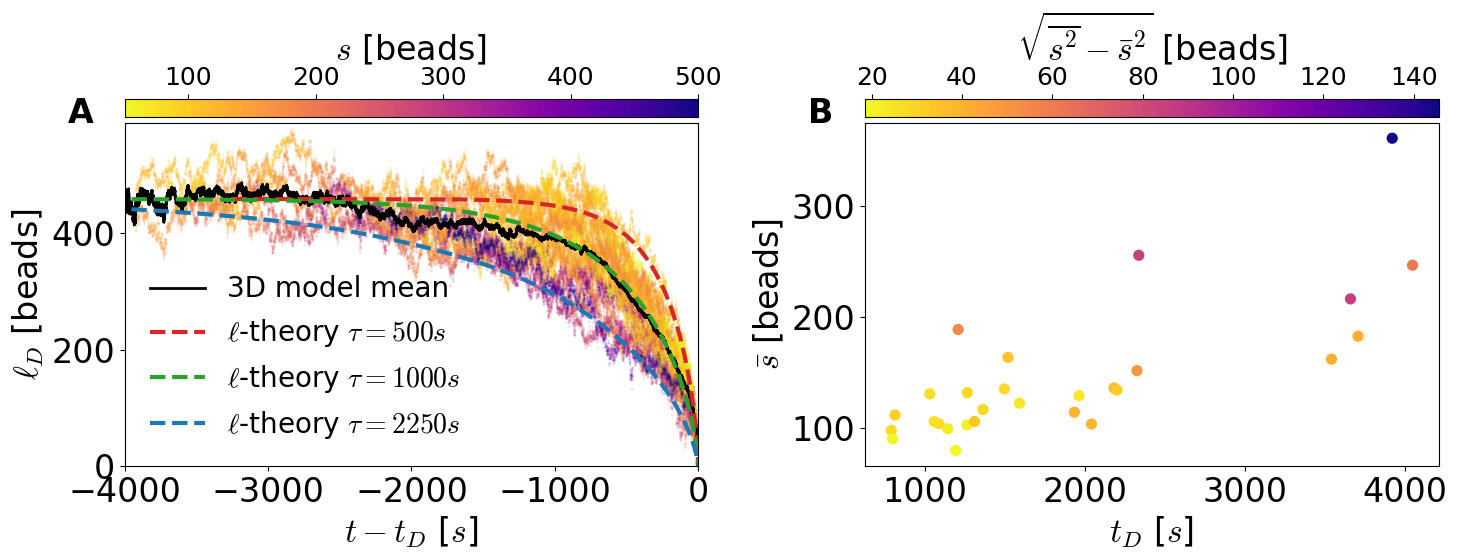

In [ ]:
fig, axarr = plt.subplots(1,2, figsize=(15,6))
plot_params = {"linewidth": 1, "markersize": .5, "marker":'', "alpha":0.3, "linestyle":'-'}

lifetime_arr = []
strand_avg_length_arr = []
strand_std_length_arr = []
cluster_size_list = []
largest_time_arr = []
max_strand_size = 0
min_strand_size = -1
vmin = 50
vmax = 500
with h5py.File("Figure7/fig7_cluster_data.h5", 'r') as h5_graph:
    dset_list = list(h5_graph['dissolve'].items())
    for i in range(0,len(h5_graph['dissolve'].items()), 2):
        name0, d_set0 = dset_list[i]
        name1, d_set1 = dset_list[i+1]
        try:
            strand_size_arr, common_times = get_strand_length(d_set0, d_set1)
            # Find dissolving dset (time indices are reversed)
            dissolve_dset = d_set0 if d_set0[0,1] < d_set1[0,1] else d_set1
            dissolve_dset = dissolve_dset[np.where(np.isin(dissolve_dset[:,0], common_times))[0]]
            time_arr = dissolve_dset[:,0]
            last_time_step = max(time_arr)
            if len(largest_time_arr) < len(time_arr):
                print(len(time_arr))
                largest_time_arr = time_arr

            lifetime_arr += [time_arr[0] - time_arr[-1]]
            strand_avg_length_arr += [np.mean(strand_size_arr)]
            strand_std_length_arr += [np.std(strand_size_arr)]

            scatter = axarr[0].scatter(time_arr-last_time_step, dissolve_dset[:,1], s=1, c=strand_size_arr, cmap='plasma_r',  vmin=vmin, vmax=vmax, alpha=0.1)
            cluster_size_list += [dissolve_dset[:,1]]

            # For sizing of scale bar purposes
            max_strand_size = max(max_strand_size, max(strand_size_arr))
            if min_strand_size == -1:
                min_strand_size = min(strand_size_arr)
            min_strand_size = min(min_strand_size, min(strand_size_arr))

        except:
            raise
            print("Error")
            print(name0, name1)
            pass

    mean_size_arr = mean_of_arrays(cluster_size_list)
    last_time_step = max(largest_time_arr)
    _ = axarr[0].plot(largest_time_arr-last_time_step, mean_size_arr, label="3D model mean", color='k')

    avg_scat = axarr[1].scatter(lifetime_arr, strand_avg_length_arr, s=50, c=strand_std_length_arr, cmap='plasma_r')

    cax2 = make_axes_locatable(axarr[1]).append_axes("top", size="5%", pad=0.06)
    cax1 = make_axes_locatable(axarr[0]).append_axes("top", size="5%", pad=0.06)

    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    sm = mpl.cm.ScalarMappable(cmap='plasma_r', norm=norm)
    cbar1 = fig.colorbar(sm,  cax=cax1, orientation='horizontal', fraction=0.02, pad=0.04, alpha=1.0)
    cbar2 = fig.colorbar(avg_scat,  cax=cax2, orientation='horizontal', fraction=0.02, pad=0.04, alpha=1.0)

    cbar1.ax.xaxis.set_ticks_position('top')
    cbar1.ax.xaxis.set_label_position('top')
    cbar1.ax.tick_params(labelsize=18)
    cbar1.set_label(r'$s$ [beads]')

    cbar2.ax.xaxis.set_ticks_position('top')
    cbar2.ax.xaxis.set_label_position('top')
    cbar2.ax.tick_params(labelsize=18)
    cbar2.set_label(r'$\sqrt{\overline{s^2} -  \bar{s}^2}$ [beads]')

# Renger et al. parameters
tmax = 1e6
kappa = 0.0822
nu = 4.1
gamma = 0.15
alpha = 0.05
beta = 1.0 / 0.0041
b = 0.01
Lc = 16
L=5

max_ld = calc_max_length_in_two_condensates(L, Lc, nu, alpha, gamma, kappa)
print(max_ld)

sol = solve_ivp(
    cond_evolve_with_tau,
    [0, tmax],
    [max_ld + 0.0001, max_ld - 0.0001],
    args=[2*max_ld, 500],
    dense_output=True,
)
t_eval = np.linspace(0, sol.t[-1], 1000)
l_eval = sol.sol(t_eval)
_ = axarr[0].plot((t_eval - t_eval[-1]), l_eval[1]/b, color="C3", label=rf"$\ell$-theory $\tau=500s$ ", linestyle="--", linewidth=3)

sol = solve_ivp(
    cond_evolve_with_tau,
    [0, tmax],
    [max_ld + 0.0001, max_ld - 0.0001],
    args=[2*max_ld, 1000],
    dense_output=True,
)
t_eval = np.linspace(0, sol.t[-1], 1000)
l_eval = sol.sol(t_eval)
_ = axarr[0].plot((t_eval - t_eval[-1]), l_eval[1]/b, color="C2", label=rf"$\ell$-theory $\tau=1000s$ ", linestyle="--", linewidth=3)

sol = solve_ivp(
    cond_evolve_with_tau,
    [0, tmax],
    [max_ld + 0.0001, max_ld - 0.0001],
    args=[2*max_ld, 2250],
    dense_output=True,
)
t_eval = np.linspace(0, sol.t[-1], 1000)
l_eval = sol.sol(t_eval)
_ = axarr[0].plot((t_eval - t_eval[-1]), l_eval[1]/b, color="C0", label=rf"$\ell$-theory $\tau=2250s$ ", linestyle="--", linewidth=3)



# sol = solve_ivp(
#     new_cond_deriv,
#     [0, tmax],
#     [max_ld + 0.0001, max_ld - 0.0001],
#     args=(2*max_ld, gamma, alpha, .021*.5),
#     dense_output=True,
# )
# t_eval = np.linspace(0, sol.t[-1], 1000)
# l_eval = sol.sol(t_eval)
# _ = axarr.plot((t_eval - t_eval[-1]), l_eval[1]/b, color="C4", label=f"New theory = {.021*.5}", linestyle="-", linewidth=3)


# sol = solve_ivp(
#     new_cond_deriv,
#     [0, tmax],
#     [max_ld + 0.0001, max_ld - 0.0001],
#     args=(2*max_ld, gamma, alpha, .021*2),
#     dense_output=True,
# )
# t_eval = np.linspace(0, sol.t[-1], 1000)
# l_eval = sol.sol(t_eval)
# _ = axarr.plot((t_eval - t_eval[-1]), l_eval[1]/b, color="C5", label=f"New theory = {.021*2}", linestyle="-", linewidth=3)

_ = axarr[0].text(-0.1, 1, "A", fontsize=24, transform=axarr[0].transAxes, fontweight='bold')
_ = axarr[1].text(-0.1, 1, "B", fontsize=24, transform=axarr[1].transAxes, fontweight='bold')
_ = axarr[0].set_ylabel("$\ell_D$ [beads]")
_ = axarr[0].set_xlabel("$t - t_D$ [$s$]")
_ = axarr[1].set_ylabel(r"$\bar{s}$ [beads]")   
_ = axarr[1].set_xlabel("$t_D$ [$s$]")
_ = axarr[0].legend(frameon=False)
_ = axarr[0].set_xlim(-4000, 0)
_ = axarr[0].set_ylim(0, 590)
fig.tight_layout()

fig.savefig("Figure8/fig8_dissolve_event_sync.png", dpi=600,bbox_inches='tight')
fig.savefig("/mnt/home/alamson/papers/dyn_cond_paper/images/fig8_dissolve_event_sync.png", dpi=300, bbox_inches="tight")


# Testing

1606
2158
4627
7307
7403
8070
4.588142181763206


/tmp/ipykernel_1768640/2984723690.py:54: RuntimeWarning: invalid value encountered in power
  return -prefactor* gamma_prime * (np.power(l, -1/3) - np.power(l_tot-l, -1/3))
/tmp/ipykernel_1768640/2984723690.py:54: RuntimeWarning: invalid value encountered in power
  return -prefactor* gamma_prime * (np.power(l, -1/3) - np.power(l_tot-l, -1/3))
/tmp/ipykernel_1768640/2984723690.py:54: RuntimeWarning: invalid value encountered in power
  return -prefactor* gamma_prime * (np.power(l, -1/3) - np.power(l_tot-l, -1/3))
/mnt/home/alamson/projects/analysis/aLENS_analysis/notebooks/chromatin_notebooks/Dyn_cond_figs/dyn_cond_fig_functions.py:295: RuntimeWarning: invalid value encountered in power
  2.0 * gamma * np.power(4.0 * np.pi * alpha * alpha / (3 * ld), 1.0 / 3.0)


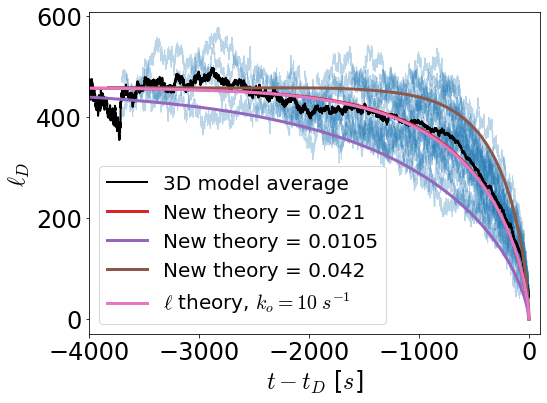

In [29]:
fig, axarr = plt.subplots(1,1, figsize=(8,6), sharey=True, sharex=True)
plot_params = {"linewidth": 1, "markersize": .5, "marker":'', "alpha":0.3, "linestyle":'-'}

cluster_size_list = []
largest_time_arr = []
with h5py.File("Figure4/fig4_cluster_data.h5", 'r') as h5_graph:
    for name, d_set in h5_graph['dissolve'].items():
        try:
            clust_arr = d_set[:,1]
            condition = clust_arr > 40

            time_arr = d_set[condition,0]
            clust_arr = clust_arr[condition]
            if min(clust_arr) < 45:
                last_time_step = max(time_arr)
                if len(largest_time_arr) < len(time_arr):
                    print(len(time_arr))
                    largest_time_arr = time_arr
                _ = axarr.plot(time_arr-last_time_step , clust_arr, color='tab:blue', **plot_params)
                cluster_size_list += [clust_arr]
        except:
            print("Error")
            print(name)
            print(d_set[:,1])
            print(d_set[:,0])
            pass
            

mean_size_arr = mean_of_arrays(cluster_size_list)
last_time_step = max(largest_time_arr)
_ = axarr.plot(largest_time_arr-last_time_step, mean_size_arr, label="3D model average", color='k')


_ = axarr.set_ylabel('$\ell_D$ ' )
_ = axarr.set_xlabel('$t - t_D$ [$s$]')


# Renger et al. parameters
tmax = 1e6
kappa = 0.0822
nu = 4.1
gamma = 0.15
alpha = 0.05
beta = 1.0 / 0.0041
b = 0.01
Lc = 16
L=5

max_ld = calc_max_length_in_two_condensates(L, Lc, nu, alpha, gamma, kappa)
print(max_ld)

def new_cond_deriv(t, l, l_tot, gamma, alpha, prefactor=.021):
    gamma_prime = 8 * np.power(6, 2.0 / 3.0) * alpha * gamma * np.cbrt(np.pi / alpha)
    return -prefactor* gamma_prime * (np.power(l, -1/3) - np.power(l_tot-l, -1/3))
    


sol = solve_ivp(
    new_cond_deriv,
    [0, tmax],
    [max_ld + 0.0001, max_ld - 0.0001],
    args=(2*max_ld, gamma, alpha),
    dense_output=True,
)
t_eval = np.linspace(0, sol.t[-1], 1000)
l_eval = sol.sol(t_eval)
_ = axarr.plot((t_eval - t_eval[-1]), l_eval[1]/b, color="C3", label=f"$\ell$-theory mid $\tau$ ", linestyle="-", linewidth=3)
# _ = axarr.plot((sol.t-sol.t[-1])/10., sol.y[1]*100, color="C4", label="$\ell$ theory $k_o = 10 s^{-1}$", linestyle="-", linewidth=3)

sol = solve_ivp(
    new_cond_deriv,
    [0, tmax],
    [max_ld + 0.0001, max_ld - 0.0001],
    args=(2*max_ld, gamma, alpha, .021*.5),
    dense_output=True,
)
t_eval = np.linspace(0, sol.t[-1], 1000)
l_eval = sol.sol(t_eval)
_ = axarr.plot((t_eval - t_eval[-1]), l_eval[1]/b, color="C4", label=f"New theory = {.021*.5}", linestyle="-", linewidth=3)

# approx = np.power(np.power((max_ld-0.001),4/3)-(.021*.25*t_eval), .75)/b
# # Find the time when approx crosses 0
# t = np.argmin(approx)
# print(t)
# _ = axarr.plot((t_eval[-t:]-t_eval[-1]), approx[:t], color="C2", label=r"$\tau$", linestyle="-", linewidth=3)

sol = solve_ivp(
    new_cond_deriv,
    [0, tmax],
    [max_ld + 0.0001, max_ld - 0.0001],
    args=(2*max_ld, gamma, alpha, .021*2),
    dense_output=True,
)
t_eval = np.linspace(0, sol.t[-1], 1000)
l_eval = sol.sol(t_eval)
_ = axarr.plot((t_eval - t_eval[-1]), l_eval[1]/b, color="C5", label=f"New theory = {.021*2}", linestyle="-", linewidth=3)

sol = solve_ivp(
    two_cond_size_continuous_deriv,
    [0, tmax],
    [max_ld + 0.001, max_ld - 0.001],
    args=(nu, gamma, alpha, kappa, L, Lc, b, beta),
    dense_output=True,
)
# _ = axarr.plot((sol.t-sol.t[-1])/30., sol.y[1]*100, color="C1", label="$\ell$ theory $k_o = 30 s^{-1}$", linestyle="-", linewidth=3)
# _ = axarr.plot((sol.t-sol.t[-1])/20., sol.y[1]*100, color="C2", label="$\ell$ theory $k_o = 20 s^{-1}$", linestyle="-", linewidth=3)
# _ = axarr.plot((sol.t-sol.t[-1])/10., sol.y[1]/b, color="C6", label="$\ell$ theory, $k_o = 10\; s^{-1}$", linestyle="-", linewidth=3)
# _ = axarr.plot((sol.t-sol.t[-1])/10., sol.y[1]*100, color="C4", label="$\ell$ theory $k_o = 10 s^{-1}$", linestyle="-", linewidth=3)
_ = axarr.set_xlim(-4000, 100)



axarr.legend()

fig.tight_layout()
# fig.savefig("Figure7/dissolve_event_sync.png", dpi=600,bbox_inches='tight')
# fig.savefig("/mnt/home/alamson/papers/dyn_cond_paper/images/fig7_dissolve_event_sync.png", dpi=300, bbox_inches="tight")

1606
2158
4627
7307
7403
8070


/mnt/home/alamson/projects/analysis/aLENS_analysis/notebooks/chromatin_notebooks/Dyn_cond_figs/dyn_cond_fig_functions.py:295: RuntimeWarning: invalid value encountered in power
  2.0 * gamma * np.power(4.0 * np.pi * alpha * alpha / (3 * ld), 1.0 / 3.0)


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


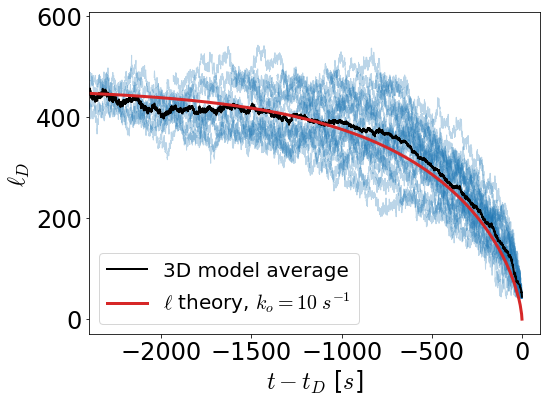

In [3]:
fig, axarr = plt.subplots(1,1, figsize=(8,6), sharey=True, sharex=True)
plot_params = {"linewidth": 1, "markersize": .5, "marker":'', "alpha":0.3, "linestyle":'-'}

cluster_size_list = []
largest_time_arr = []
with h5py.File("Figure4/fig4_cluster_data.h5", 'r') as h5_graph:
    for name, d_set in h5_graph['dissolve'].items():
        try:
            clust_arr = d_set[:,1]
            condition = clust_arr > 40

            time_arr = d_set[condition,0]
            clust_arr = clust_arr[condition]
            if min(clust_arr) < 45:
                last_time_step = max(time_arr)
                if len(largest_time_arr) < len(time_arr):
                    print(len(time_arr))
                    largest_time_arr = time_arr
                _ = axarr.plot(time_arr-last_time_step , clust_arr, color='tab:blue', **plot_params)
                cluster_size_list += [clust_arr]
        except:
            print("Error")
            print(name)
            print(d_set[:,1])
            print(d_set[:,0])
            pass
            

mean_size_arr = mean_of_arrays(cluster_size_list)
last_time_step = max(largest_time_arr)
_ = axarr.plot(largest_time_arr-last_time_step, mean_size_arr, label="3D model average", color='k')


_ = axarr.set_ylabel('$\ell_D$ ' )
_ = axarr.set_xlabel('$t - t_D$ [$s$]')


# Renger et al. parameters
tmax = 1e6
kappa = 0.0822
nu = 4.1
gamma = 0.15
alpha = 0.05
beta = 1.0 / 0.0041
b = 0.01
Lc = 16
L=5

max_ld = calc_max_length_in_two_condensates(L, Lc, nu, alpha, gamma, kappa)


sol = solve_ivp(
    two_cond_size_continuous_deriv,
    [0, tmax],
    [max_ld + 0.001, max_ld - 0.001],
    args=(nu, gamma, alpha, kappa, L, Lc, b, beta),
    dense_output=True,
)
# _ = axarr.plot((sol.t-sol.t[-1])/30., sol.y[1]*100, color="C1", label="$\ell$ theory $k_o = 30 s^{-1}$", linestyle="-", linewidth=3)
# _ = axarr.plot((sol.t-sol.t[-1])/20., sol.y[1]*100, color="C2", label="$\ell$ theory $k_o = 20 s^{-1}$", linestyle="-", linewidth=3)
_ = axarr.plot((sol.t-sol.t[-1])/10., sol.y[1]*100, color="C3", label="$\ell$ theory, $k_o = 10\; s^{-1}$", linestyle="-", linewidth=3)
# _ = axarr.plot((sol.t-sol.t[-1])/10., sol.y[1]*100, color="C4", label="$\ell$ theory $k_o = 10 s^{-1}$", linestyle="-", linewidth=3)
_ = axarr.set_xlim(-2400, 100)

axarr.legend()

fig.tight_layout()
fig.savefig("Figure7/dissolve_event_sync.png", dpi=600,bbox_inches='tight')
fig.savefig("/mnt/home/alamson/papers/dyn_cond_paper/images/fig7_dissolve_event_sync.png", dpi=300, bbox_inches="tight")

In [4]:
sim_path = ceph_path / "24-03-08_aLc1_slice5.5.13_line1600_Pin3-11um_2xKe3-300_ks100/simulations/Ke30_Pin5.0um/s2/analysis/raw_data.h5"

import h5py
import numpy as np
sim_path = 'raw_data_s1.h5'
with h5py.File(sim_path, 'r') as h5_data:
    # Read in parameters for system and proteins
    param_dict = yaml.load(h5_data.attrs['RunConfig'], Loader=yaml.FullLoader)  
    protein_dict = yaml.load(h5_data.attrs['ProteinConfig'], Loader=yaml.FullLoader)  
    box_lower = np.array(param_dict['simBoxLow'])
    box_upper = np.array(param_dict['simBoxHigh'])

    # Load in time array
    time_arr = h5_data['time'][:] # Load in time array, [:] loads data as numpy array

    # Load in sylinder data 
    sy_dat = h5_data['raw_data/sylinders']
    # Print dimensions of sylinder data matrix
    print(sy_dat.attrs['axis dimensions'])
    # Print information about the second axis of protein data
    print(sy_dat.attrs['column labels'])

    ## INFORMATION USEFUL FOR YOU
    # Get center of particles in time and spatial coordinates (particle index, [x/y/z], time step)
    com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])


    ## EXTRA INFORMATION
    # Get sticky end data if necessary
    prot_dat = h5_data['raw_data/proteins']
    # Print data about second axis of protein data
    print(prot_dat.attrs['column labels'])

['sylinders' 'state' 'frame']
['gid' 'radius' 'minus pos x' 'minus pos y' 'minus pos z' 'plus pos x'
 'plus pos y' 'plus pos z' 'group']
['gid' 'tag' 'end1 pos x' 'end1 pos y' 'end1 pos z' 'end2 pos x'
 'end2 pos y' 'end2 pos z' 'end1 bindID' 'end2 bindID']


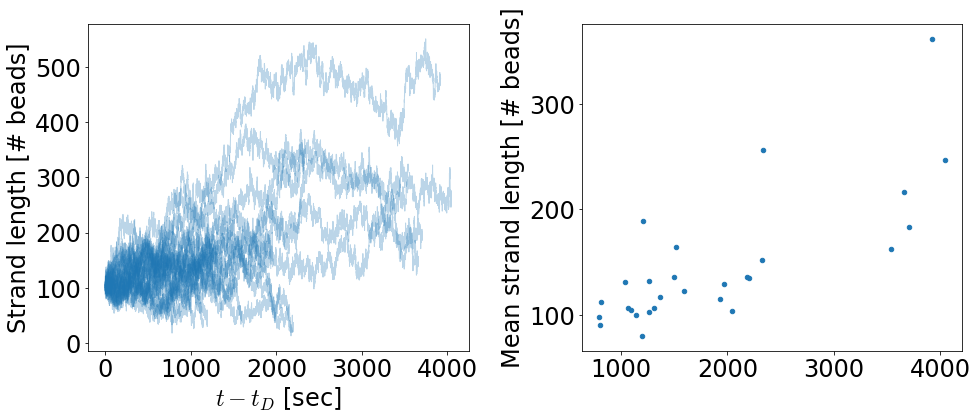

In [21]:
fig, axarr = plt.subplots(1,2, figsize=(14,6))
plot_params = {"linewidth": 1, "markersize": .5, "marker":'', "alpha":0.3, "linestyle":'-'}

def get_strand_length(dset0, dset1):

    time_arr0 = dset0[:,0]
    time_arr1 = dset1[:,0]
    common_times = np.intersect1d(time_arr0, time_arr1)
    dset_common0 = dset0[np.where(np.isin(time_arr0, common_times))[0]]
    dset_common1 = dset1[np.where(np.isin(time_arr1, common_times))[0]]

    clust_size_arr0 = dset_common0[:,1]
    clust_center_arr0 = dset_common0[:,2]
    left_edge0 = clust_center_arr0 - clust_size_arr0*.5
    right_edge0 = clust_center_arr0 + clust_size_arr0*.5

    clust_size_arr1 = dset_common1[:,1]
    clust_center_arr1 = dset_common1[:,2]
    left_edge1 = clust_center_arr1 - clust_size_arr1*.5
    right_edge1 = clust_center_arr1 + clust_size_arr1*.5

    strand_size = left_edge1 - right_edge0 if left_edge1[0] - right_edge0[0] > 0 else left_edge0 - right_edge1

    return strand_size, common_times

cluster_size_list = []
largest_time_arr = []
lifetime_arr = []
strand_avg_length_arr = []
with h5py.File("Figure4/fig4_cluster_data.h5", 'r') as h5_graph:
    dset_list = list(h5_graph['dissolve'].items())
    for i in range(0,len(h5_graph['dissolve'].items()), 2):
        name0, d_set0 = dset_list[i]
        name1, d_set1 = dset_list[i+1]
        try:
            # print(name0, name1)
            strand_size_arr, common_times = get_strand_length(d_set0, d_set1)
            time_arr = d_set0[np.isin(d_set0[:,0], common_times),0]
            last_time_step = max(time_arr)
            _ = axarr[0].plot(time_arr, strand_size_arr, color='tab:blue', **plot_params)
            lifetime_arr += [time_arr[0] - time_arr[-1]]
            strand_avg_length_arr += [np.mean(strand_size_arr)]

        except:
            raise
            print("Error")
            print(name0, name1)
            # print(d_set[:,1])
            # print(d_set[:,0])
            pass
    _ = axarr[1].scatter(lifetime_arr, strand_avg_length_arr, s=20, color='tab:blue')
    _ = axarr[0].set_xlabel("$t_D$ [sec]")
    _ = axarr[1].set_ylabel("Mean strand length [# beads]")   
    _ = axarr[0].set_ylabel("Strand length [# beads]")
    _ = axarr[0].set_xlabel("$t - t_D$ [sec]")
    fig.tight_layout()

/tmp/ipykernel_2501797/2737901160.py:59: MatplotlibDeprecationWarning: The 'alpha' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = fig.colorbar(scatter,  cax=cax1, orientation='horizontal', fraction=0.02, pad=0.04, alpha=1.0)


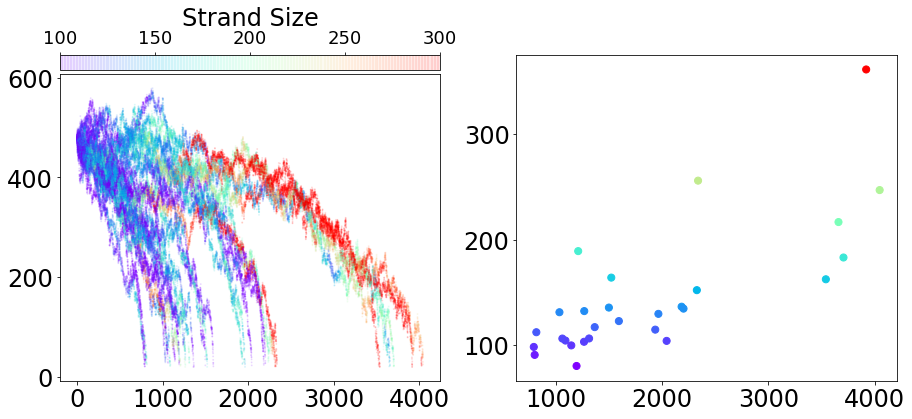

In [7]:
fig, axarr = plt.subplots(1,2, figsize=(15,6))
plot_params = {"linewidth": 1, "markersize": .5, "marker":'', "alpha":0.3, "linestyle":'-'}

def get_strand_length(dset0, dset1):

    time_arr0 = dset0[:,0]
    time_arr1 = dset1[:,0]
    common_times = np.intersect1d(time_arr0, time_arr1)
    dset_common0 = dset0[np.where(np.isin(time_arr0, common_times))[0]]
    dset_common1 = dset1[np.where(np.isin(time_arr1, common_times))[0]]

    clust_size_arr0 = dset_common0[:,1]
    clust_center_arr0 = dset_common0[:,2]
    left_edge0 = clust_center_arr0 - clust_size_arr0*.5
    right_edge0 = clust_center_arr0 + clust_size_arr0*.5

    clust_size_arr1 = dset_common1[:,1]
    clust_center_arr1 = dset_common1[:,2]
    left_edge1 = clust_center_arr1 - clust_size_arr1*.5
    right_edge1 = clust_center_arr1 + clust_size_arr1*.5

    strand_size = left_edge1 - right_edge0 if left_edge1[0] - right_edge0[0] > 0 else left_edge0 - right_edge1

    return strand_size, common_times


lifetime_arr = []
strand_avg_length_arr = []
with h5py.File("Figure4/fig4_cluster_data.h5", 'r') as h5_graph:
    dset_list = list(h5_graph['dissolve'].items())
    for i in range(0,len(h5_graph['dissolve'].items()), 2):
        name0, d_set0 = dset_list[i]
        name1, d_set1 = dset_list[i+1]
        try:
            # print(name0, name1)
            strand_size_arr, common_times = get_strand_length(d_set0, d_set1)
            # time_arr = d_set0[np.isin(d_set0[:,0], common_times),0]
            # Find dissolving dset (time indices are reversed)
            dissolve_dset = d_set0 if d_set0[0,1] < d_set1[0,1] else d_set1
            dissolve_dset = dissolve_dset[np.where(np.isin(dissolve_dset[:,0], common_times))[0]]
            time_arr = dissolve_dset[:,0]

            last_time_step = max(time_arr)
            lifetime_arr += [time_arr[0] - time_arr[-1]]
            strand_avg_length_arr += [np.mean(strand_size_arr)]

            # _ = axarr[0].plot(time_arr-last_time_step , dissolve_dset[:,1], color='tab:blue', **plot_params)
            scatter = axarr[0].scatter(time_arr, dissolve_dset[:,1], s=1, c=strand_size_arr, cmap='rainbow',  vmin=100, vmax=300, alpha=0.1)

        except:
            raise
            print("Error")
            print(name0, name1)
            # print(d_set[:,1])
            # print(d_set[:,0])
            pass

    cax1 = make_axes_locatable(axarr[0]).append_axes("top", size="5%", pad=0.06)
    cbar = fig.colorbar(scatter,  cax=cax1, orientation='horizontal', fraction=0.02, pad=0.04, alpha=1.0)
    cbar.ax.xaxis.set_ticks_position('top')
    cbar.ax.xaxis.set_label_position('top')
    cbar.ax.tick_params(labelsize=18)
    cbar.set_label('Strand Size')
    _ = axarr[1].scatter(lifetime_arr, strand_avg_length_arr, s=50, c=strand_avg_length_arr, cmap='rainbow')

/tmp/ipykernel_2510057/4213814888.py:60: MatplotlibDeprecationWarning: The 'alpha' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = fig.colorbar(scatter,  cax=cax1, orientation='horizontal', fraction=0.02, pad=0.04, alpha=1.0)


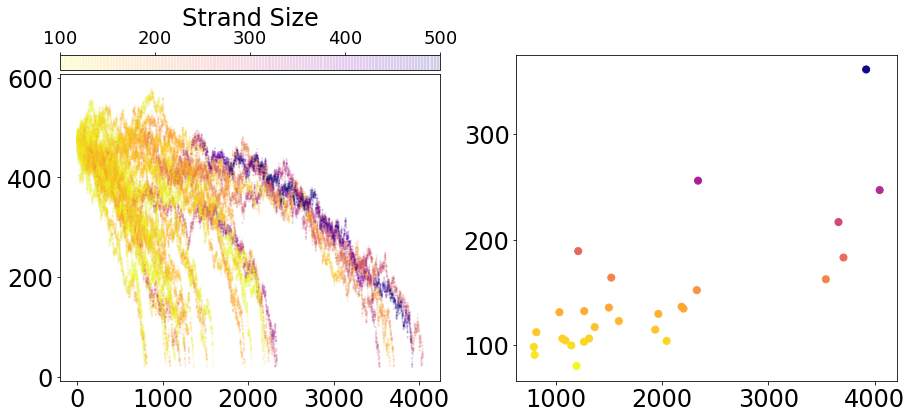

In [32]:
fig, axarr = plt.subplots(1,2, figsize=(15,6))
plot_params = {"linewidth": 1, "markersize": .5, "marker":'', "alpha":0.3, "linestyle":'-'}

def get_strand_length(dset0, dset1):

    time_arr0 = dset0[:,0]
    time_arr1 = dset1[:,0]
    common_times = np.intersect1d(time_arr0, time_arr1)
    dset_common0 = dset0[np.where(np.isin(time_arr0, common_times))[0]]
    dset_common1 = dset1[np.where(np.isin(time_arr1, common_times))[0]]

    clust_size_arr0 = dset_common0[:,1]
    clust_center_arr0 = dset_common0[:,2]
    left_edge0 = clust_center_arr0 - clust_size_arr0*.5
    right_edge0 = clust_center_arr0 + clust_size_arr0*.5

    clust_size_arr1 = dset_common1[:,1]
    clust_center_arr1 = dset_common1[:,2]
    left_edge1 = clust_center_arr1 - clust_size_arr1*.5
    right_edge1 = clust_center_arr1 + clust_size_arr1*.5

    strand_size = left_edge1 - right_edge0 if left_edge1[0] - right_edge0[0] > 0 else left_edge0 - right_edge1

    return strand_size, common_times


lifetime_arr = []
strand_avg_length_arr = []
strand_std_length_arr = []
with h5py.File("Figure4/fig4_cluster_data.h5", 'r') as h5_graph:
    dset_list = list(h5_graph['dissolve'].items())
    for i in range(0,len(h5_graph['dissolve'].items()), 2):
        name0, d_set0 = dset_list[i]
        name1, d_set1 = dset_list[i+1]
        try:
            # print(name0, name1)
            strand_size_arr, common_times = get_strand_length(d_set0, d_set1)
            # time_arr = d_set0[np.isin(d_set0[:,0], common_times),0]
            # Find dissolving dset (time indices are reversed)
            dissolve_dset = d_set0 if d_set0[0,1] < d_set1[0,1] else d_set1
            dissolve_dset = dissolve_dset[np.where(np.isin(dissolve_dset[:,0], common_times))[0]]
            time_arr = dissolve_dset[:,0]

            last_time_step = max(time_arr)
            lifetime_arr += [time_arr[0] - time_arr[-1]]
            strand_avg_length_arr += [np.mean(strand_size_arr)]

            # _ = axarr[0].plot(time_arr-last_time_step , dissolve_dset[:,1], color='tab:blue', **plot_params)
            scatter = axarr[0].scatter(time_arr, dissolve_dset[:,1], s=1, c=strand_size_arr, cmap='plasma_r',  vmin=100, vmax=500, alpha=0.1)

        except:
            raise
            print("Error")
            print(name0, name1)
            # print(d_set[:,1])
            # print(d_set[:,0])
            pass

    cax1 = make_axes_locatable(axarr[0]).append_axes("top", size="5%", pad=0.06)
    cbar = fig.colorbar(scatter,  cax=cax1, orientation='horizontal', fraction=0.02, pad=0.04, alpha=1.0)
    cbar.ax.xaxis.set_ticks_position('top')
    cbar.ax.xaxis.set_label_position('top')
    cbar.ax.tick_params(labelsize=18)
    cbar.set_label('Strand Size')
    _ = axarr[1].scatter(lifetime_arr, strand_avg_length_arr, s=50, c=strand_avg_length_arr, cmap='plasma_r')

/tmp/ipykernel_2501797/2251946645.py:58: MatplotlibDeprecationWarning: The 'alpha' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = fig.colorbar(scatter,  cax=cax1, orientation='horizontal', fraction=0.02, pad=0.04, alpha=1.0)


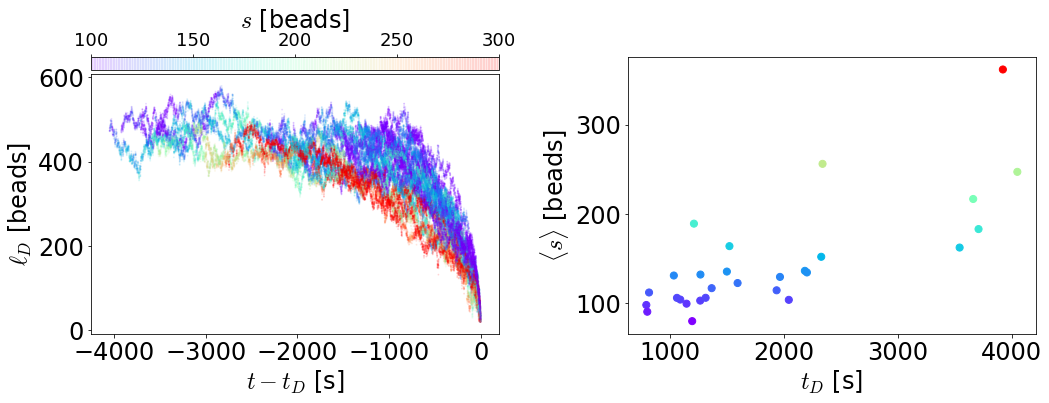

In [6]:
fig, axarr = plt.subplots(1,2, figsize=(15,6))
plot_params = {"linewidth": 1, "markersize": .5, "marker":'', "alpha":0.3, "linestyle":'-'}

def get_strand_length(dset0, dset1):

    time_arr0 = dset0[:,0]
    time_arr1 = dset1[:,0]
    common_times = np.intersect1d(time_arr0, time_arr1)
    dset_common0 = dset0[np.where(np.isin(time_arr0, common_times))[0]]
    dset_common1 = dset1[np.where(np.isin(time_arr1, common_times))[0]]

    clust_size_arr0 = dset_common0[:,1]
    clust_center_arr0 = dset_common0[:,2]
    left_edge0 = clust_center_arr0 - clust_size_arr0*.5
    right_edge0 = clust_center_arr0 + clust_size_arr0*.5

    clust_size_arr1 = dset_common1[:,1]
    clust_center_arr1 = dset_common1[:,2]
    left_edge1 = clust_center_arr1 - clust_size_arr1*.5
    right_edge1 = clust_center_arr1 + clust_size_arr1*.5

    strand_size = left_edge1 - right_edge0 if left_edge1[0] - right_edge0[0] > 0 else left_edge0 - right_edge1

    return strand_size, common_times

lifetime_arr = []
strand_avg_length_arr = []
with h5py.File("Figure4/fig4_cluster_data.h5", 'r') as h5_graph:
    dset_list = list(h5_graph['dissolve'].items())
    for i in range(0,len(h5_graph['dissolve'].items()), 2):
        name0, d_set0 = dset_list[i]
        name1, d_set1 = dset_list[i+1]
        try:
            # print(name0, name1)
            strand_size_arr, common_times = get_strand_length(d_set0, d_set1)
            # time_arr = d_set0[np.isin(d_set0[:,0], common_times),0]
            # Find dissolving dset (time indices are reversed)
            dissolve_dset = d_set0 if d_set0[0,1] < d_set1[0,1] else d_set1
            dissolve_dset = dissolve_dset[np.where(np.isin(dissolve_dset[:,0], common_times))[0]]
            time_arr = dissolve_dset[:,0]
            last_time_step = max(time_arr)

            lifetime_arr += [time_arr[0] - time_arr[-1]]
            strand_avg_length_arr += [np.mean(strand_size_arr)]


            scatter = axarr[0].scatter(time_arr-last_time_step, dissolve_dset[:,1], s=1, c=strand_size_arr, cmap='rainbow',  vmin=100, vmax=300, alpha=0.1)

        except:
            raise
            print("Error")
            print(name0, name1)
            # print(d_set[:,1])
            # print(d_set[:,0])
            pass

    cax1 = make_axes_locatable(axarr[0]).append_axes("top", size="5%", pad=0.06)
    cbar = fig.colorbar(scatter,  cax=cax1, orientation='horizontal', fraction=0.02, pad=0.04, alpha=1.0)
    cbar.ax.xaxis.set_ticks_position('top')
    cbar.ax.xaxis.set_label_position('top')
    cbar.ax.tick_params(labelsize=18)
    cbar.set_label(r'$s$ [beads]')
    _ = axarr[1].scatter(lifetime_arr, strand_avg_length_arr, s=50, c=strand_avg_length_arr, cmap='rainbow')

    _ = axarr[0].set_ylabel("$\ell_D$ [beads]")
    _ = axarr[0].set_xlabel("$t - t_D$ [s]")
    _ = axarr[1].set_ylabel(r"$\langle s \rangle$ [beads]")   
    _ = axarr[1].set_xlabel("$t_D$ [s]")
    fig.tight_layout()
